In [145]:
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

In [139]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss','BAF','score','germlineOrSomatic','oneOrZero']
GENECNV_COLUMNS = ['patientName','gene','chrom','posStart','posEnd','minCopyNum','cnvLabel']

In [208]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"  #HMF_Slicing.bed
BED_FILE_NAME = "HMF_Slicing.bed" 
USE_BED = True
LOAD_FULL_FILE = True

### FUNCTIONS

In [4]:
def findFiles(path,suffix):
    files=[]
    for x in os.listdir(path):
        if x[-len(suffix):] == suffix:
            files.append(x)
    return files

In [5]:
def loadCNVforPatient(cnvFile,patientName):
    dfTumorCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #add regions with default copy number
    last = dfTumorCNV.iloc[0]
    for i in range(1, dfTumorCNV.shape[0]-1):
        if last['posEnd']<>dfTumorCNV.iloc[i]['posStart']:
            if last['chrom']==dfTumorCNV.iloc[i]['chrom']:
                dfTumorCNV.loc[len(dfTumorCNV)] = [last['chrom'],last['posEnd'], dfTumorCNV.iloc[i]['posStart']-1,2,'none','','',0,0]
            else:
                dfTumorCNV.loc[len(dfTumorCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none','','',0,0]
                if dfTumorCNV.iloc[i]['posStart']<>0:
                    dfTumorCNV.loc[len(dfTumorCNV)] = [dfTumorCNV.iloc[i]['chrom'],0, dfTumorCNV.iloc[i]['posStart'],2,'none','','',0,0]
        last = dfTumorCNV.iloc[i]
    #fix first record
    if dfTumorCNV.iloc[0]['posStart']<>0:
        dfTumorCNV.loc[len(dfTumorCNV)] = ['1',0, dfTumorCNV.iloc[0]['posStart'],2,'none','','',0,0]
    #Additional Fields
    dfTumorCNV['chromPos']= dfTumorCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfTumorCNV['posStart'] / dfTumorCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfTumorCNV['chrom'] = dfTumorCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfTumorCNV['cappedCopyNum'] = dfTumorCNV['copyNum'].clip(upper=5)
    dfTumorCNV = dfTumorCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfTumorCNV['regionLength'] = (dfTumorCNV['posEnd']-dfTumorCNV['posStart'])
    dfTumorCNV['patientName']=patientName
    return dfTumorCNV

In [6]:
def calculateMBAFBetween(chrom,minPos,maxPos):
    dftemp = dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]
    return dftemp['mBAF'].median(),dftemp['mBAF'].count()

In [7]:
def loadBAFData(bafFile):
    df = pd.read_table(bafFile)
    return df

In [8]:
def cnvChart(dfTumorCNV,filename,minChrom=1,maxChrom=23):
    plt.figure(figsize=[18,3])
    plt.title(filename)
    ax = plt.gca()
    ax.plot(dfTumorCNV['chromPos'], dfTumorCNV['copyNum'],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, 6])
       

In [9]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [61]:
len(dfGermline[(dfGermline['variantType']=="SNP")&(dfGermline['tumorSGT']=="0/1")&(dfGermline['tumorAF']>0.4) \
                   &(dfGermline['tumorAF']<0.65)&(dfGermline['tumorDP']>50)&\
                   (dfGermline['tumorDP']<100)])

174719

In [70]:
def createBAF(dfGermline):
    dfBAF = dfGermline[(dfGermline['variantType']=="SNP")&(dfGermline['normalSGT']=="0/1")&(dfGermline['normalAF']>0.4) \
                   &(dfGermline['normalAF']<0.65)&(dfGermline['normalDP']>50)&\
                   (dfGermline['normalDP']<100)][['chrom','pos','tumorAF']]
    dfBAF.columns = ['Chromosome', 'Position','BAF']
    dfBAF['Position'] = pd.to_numeric(dfBAF['Position'])
    dfBAF['mBAF']= 0.5+abs(dfBAF['BAF']-0.5)
    dfBAF['chromPos']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x)) + dfBAF['Position'] / dfBAF['Chromosome'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfBAF['Chromosome']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x))
    return dfBAF

In [11]:
def patientIDFromFilename(filename):
    patientIDStart = filename.find("CPCT02")
    return filename[patientIDStart:patientIDStart+12]

In [12]:
def germlineVCFSampleNames(filename,patientID):
    return {patientID+'R':'normal',patientID+'T':'tumor'}

In [13]:
def loadVCF(path,filename,sampleNames,patientID):
    df = pd.DataFrame()
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True,True,bed,LOAD_FULL_FILE)])
    else:
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True)])

In [14]:
def AFByPosPlot(pos,AF,startChartPos,endChartPos):
    plt.figure(figsize=[18,5])
    plt.scatter(pos, AF)
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.axis([startChartPos, endChartPos,0, 1.0])
    plt.show()

In [15]:
def loadPON(aPath,aPONFile):
    myPON = []
    with open(aPath + aPONFile, 'r') as f:
        for line in f:
            line = line.strip('\n')
            splitLine = line.split('\t')
            myPON.append(splitLine)
    dfPON = pd.DataFrame(myPON)
    dfPON.columns = ['chrom','pos','ref','alt','PONCount']
    return dfPON

In [99]:
def positionChart(dfCNV,filename,fieldName,minChrom=1,maxChrom=23,maxValue=10):
    plt.figure(figsize=[18,3])
    plt.title(filename+" "+fieldName)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV[fieldName],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, maxValue])

In [102]:
def findPeaks(log_dens,X_range):
    peaks = []
    troughs = []
    dens=np.exp(log_dens)
    diff = [dens[x] - dens[x-1] for x in range(1,len(dens))]
    for i in range (len(diff)-1):
        if diff[i+1] < 0 and diff[i] > 0:
            peaks.append(float(i+1)/len(dens)*X_range)
        if diff[i+1] > 0 and diff[i] < 0:
            troughs.append(float(i+1)/len(dens)*X_range)
    return peaks#, troughs

In [96]:
def nonZeroCountBetween(chrom,minPos,maxPos):
    temp = dfTumorRatio[(dfTumorRatio.Chromosome==chrom)&(dfTumorRatio.Start>minPos)&\
                       (dfTumorRatio.Start<maxPos)&(dfTumorRatio.Ratio_x<>-1)]
    return temp['Start'].count(),temp['Ratio_x'].mean(),temp['Ratio_y'].mean(),temp['MedianRatio_x'].mean(),temp['MedianRatio_y'].mean()

In [111]:
def fitBAFPeak(mBAF):
    return min(mBAFPeaks, key=lambda x:abs(x-mBAF))

def fitCNVPeak(ratio):
    return min(cnvPeaks, key=lambda x:abs(x-ratio))

In [212]:
def pdfChart(log_dens,maxYValue=8):
    fig, ax = plt.subplots()
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format('gaussian'))
    ax.legend(loc='upper right')
    fig.set_figwidth(10)
    fig.set_figheight(2)
    #ax.set_xlim(0, 1)
    ax.set_ylim(-0.02, maxYValue)
    ax.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.show()

In [189]:
def runGeneCNVAnalysis(dfCNV,bed,patientName):
    geneList =[]
    for bedrow in bed:
        bedChromPosStart = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        bedChromPosEnd = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        prevCNV = max(dfCNV[(dfCNV['chromPos'] < bedChromPosStart)].index.tolist())
        if dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist():
            nextCNV = min(dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist())
            minCopyNum = min(([dfCNV.iloc[x]['myCopyNum']]) for x in range (prevCNV,nextCNV)) 
        else:
            minCopyNum = [-1]
        geneList.append([patientName,bedrow[3],bedrow[0],bedrow[1],bedrow[2],minCopyNum[0],cnvLabel(minCopyNum[0])])
    return geneList

### LOAD PON

In [18]:
# Only needs to be run once
dfPON = loadPON("/Users/peterpriestley/hmf/analyses/PON/779filePON/","PON.tsv")

### FIND ALL FILES

In [19]:
PATH = "/Users/peterpriestley/hmf/analyses/COLO829/"

In [91]:
germlineVCFFilename = findFiles(PATH,"SLICED.vcf")[0]
somaticVCFFilename = findFiles(PATH,"melted.vcf")[0]
patientID = "COLO829"
tumorCNVFileName=findFiles(PATH,"gz_CNVs")[0]
normalCNVFileName=findFiles(PATH,"normal_CNVs")[0]
tumorRatioFileName=findFiles(PATH,"gz_ratio.txt")[0]
normalRatioFileName=findFiles(PATH,"gz_normal_ratio.txt")[0]
print "germline =",germlineVCFFilename
print "somatic =",somaticVCFFilename
print "patient =",patientID
print "CNV =",cnvFilename

germline = 170310_COLO829_v1.12_Somatic.annotatedSLICED.vcf
somatic = COLO829BL_COLO829_melted.vcf
patient = COLO829
CNV = COLO829_dedup.realigned.pileup.gz_CNVs


### LOAD VCFS

In [209]:
#LOAD VCFS
dfGermline = loadVCF(PATH,germlineVCFFilename,{patientID+'BL':'normal',patientID:'tumor'},patientID)
dfSomatic = loadVCF(PATH,somaticVCFFilename,{patientID:'melted'},patientID)

reading vcf file: COLO829BL_COLO829_melted.vcf
reading VCF File line: 1
Number variants loaded: 87269


In [210]:
# APPLY PON to SOMATICs
dfSomatic['alt'] = dfSomatic['meltedallele']
dfSomatic = pd.merge(dfSomatic,dfPON,how='left', on=['chrom','pos','ref','alt'])
dfSomatic['PONCount'].fillna(0, inplace=True)
dfSomatic['inPON'] = pd.to_numeric(dfSomatic.PONCount,errors=coerce)>4

### Load BAF and CNV and calculate median BAF per segment

In [67]:
dfBAF = createBAF(dfGermline)

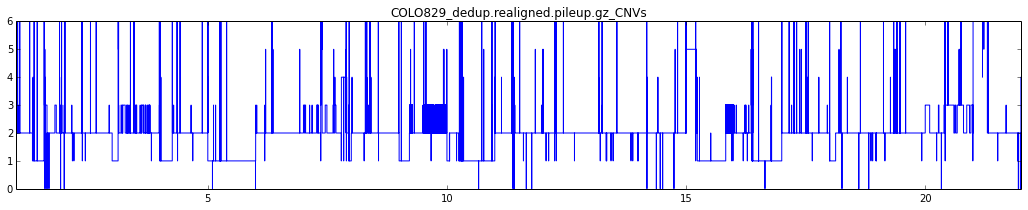

In [92]:
dfTumorCNV = loadCNVforPatient(PATH+tumorCNVFileName,patientID)
dfNormalCNV = loadCNVforPatient(PATH+normalCNVFileName,patientID)
dfTumorCNV['mBAF'], dfTumorCNV['mBAFCount'] = np.vectorize(calculateMBAFBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])
cnvChart(dfTumorCNV,cnvFilename,1,22)

### TUMOR PURITY

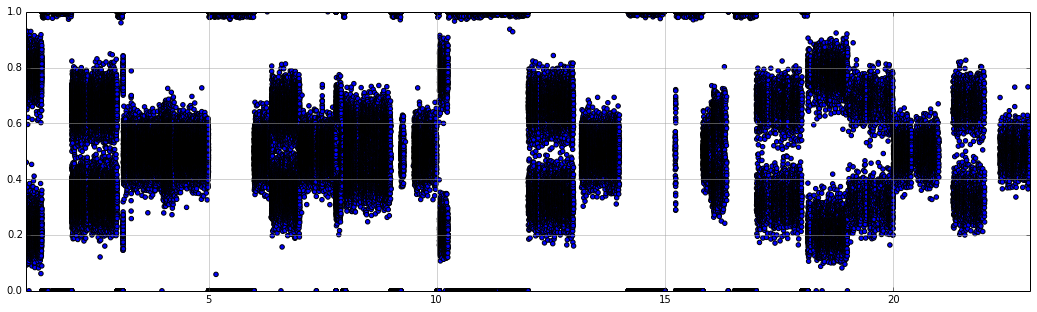

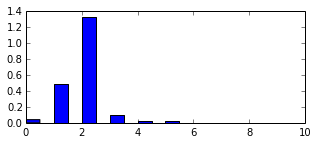

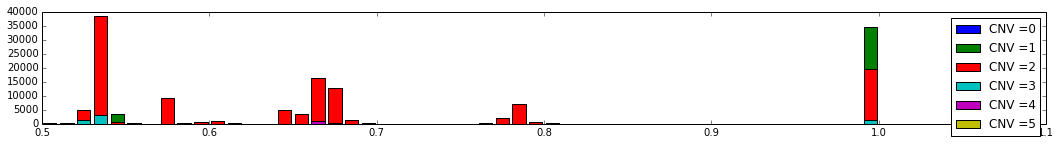

In [213]:
c = 1
fractionMin = 0
fractionMax = 22
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfSom.chromPos, dfSom.BAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0, 1.0])
plt.show()
# CNV according to freeC
plt.figure(figsize=[5,2])
plt.hist(dfTumorCNV['copyNum'].values,cumulative=False, normed=True, bins=20,range=(0,10),weights=dfTumorCNV['regionLength'].values)
plt.show()
# should only use regions with mbaf > x
c,fractionMin,fractionMax = 1,0,22
dftemp = dfTumorCNV[(dfTumorCNV.mBAF>=0.0)&(dfTumorCNV.mBAF<=1.0)&(dfTumorCNV.mBAFCount>20)&(dfTumorCNV.chromPos<=c+fractionMax)&(dfTumorCNV.chromPos>=c+fractionMin)]
plt.figure(figsize=[18,2])
for CNV in range(0,6):
    plt.hist(dftemp[(dftemp.copyNum==CNV)]['mBAF'].values,cumulative=False, normed=False, bins=50,range=(0.5,1.0),weights=dftemp[(dftemp.copyNum==CNV)]['mBAFCount'].values,stacked = True,rwidth=0.8,label='CNV ='+str(CNV))
    plt.legend()
plt.show()

In [248]:
dfTumorCNV[(dfTumorCNV.chrom>0)&(dfTumorCNV.copyNum>=1)&(dfTumorCNV.mBAF>0.56)&(dfTumorCNV.mBAF<0.62)\
      &(dfTumorCNV.mBAFCount>50)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount','ratioOfRatio']]

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount,ratioOfRatio
546,8,0,2,8.000000,2195000,0.574856,190,1.080706
550,8,2557000,2,8.017470,36674999,0.574074,3239,1.034996
552,8,39387000,2,8.269103,3704999,0.575758,175,1.025151
569,8,47541000,2,8.324813,5188999,0.572816,193,1.016452
571,8,52733000,2,8.360287,4021999,0.570714,276,1.003995
573,8,56756000,2,8.387773,1365999,0.572917,93,1.000317
575,8,58123000,2,8.397113,2011999,0.581017,152,1.006179
577,8,60137000,2,8.410873,22616999,0.574257,1266,1.003689
581,8,83296000,2,8.569102,61454999,0.572917,3803,1.019738
2286,16,1913000,2,16.021172,2270999,0.596037,52,1.060532


### SOMATIC AF

In [28]:
#dfSomatic[(dfSomatic.consensus==True)&((dfSomatic.annWorstImpact=='MODERATE')|(dfSomatic.annWorstImpact=='HIGH'))]

In [88]:
pd.pivot_table(dfSomatic[dfSomatic.consensus==True], values='pos', index=['patientName','variantType','inPON'], columns=['annWorstImpact'], aggfunc='count',margins=False).fillna("")

annWorstImpact                         HIGH     LOW  MODERATE  MODIFIER
patientName variantType inPON                                          
COLO829     INDEL       False    521.0    4   136.0       2.0     278.0
                        True     624.0    1   182.0       3.0     440.0
            SNP         False  22161.0   23  5464.0     194.0   12420.0
                        True     462.0         79.0       1.0     216.0

In [30]:
pd.pivot_table(dfSomatic[(dfSomatic.variantType == 'SNP')&(dfSomatic.consensus == True)&(dfSomatic.inPON == False)], values='pos', index=['ref'], columns=['meltedallele'], aggfunc='count',margins=True).fillna("")

meltedallele,A,C,G,T,All
ref,,,,,
A,,830,1214,869,2913.0
C,2121,,384,14306,16811.0
G,14755,406,,2295,17456.0
T,853,1276,953,,3082.0
All,17729,2512,2551,17470,40262.0


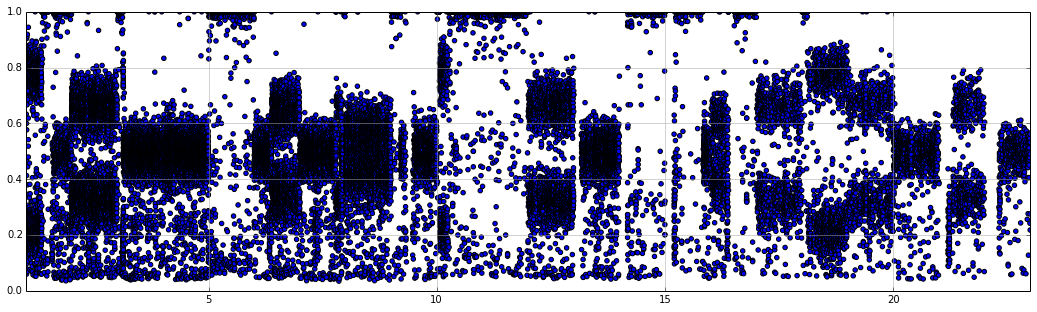

In [200]:
c,fractionMin,fractionMax = 1,0,22
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

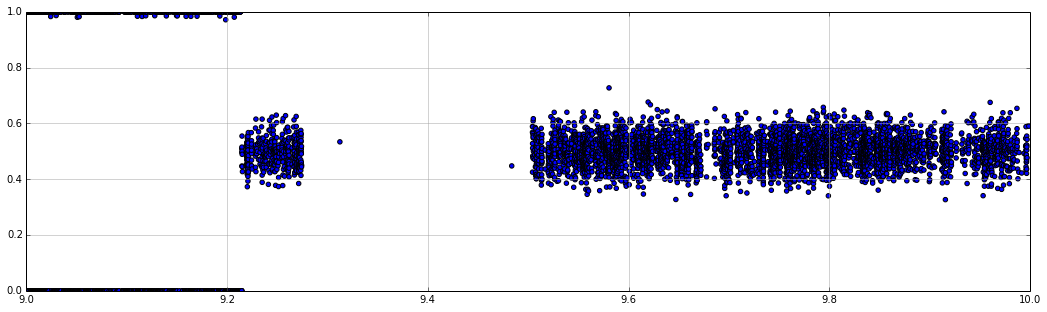

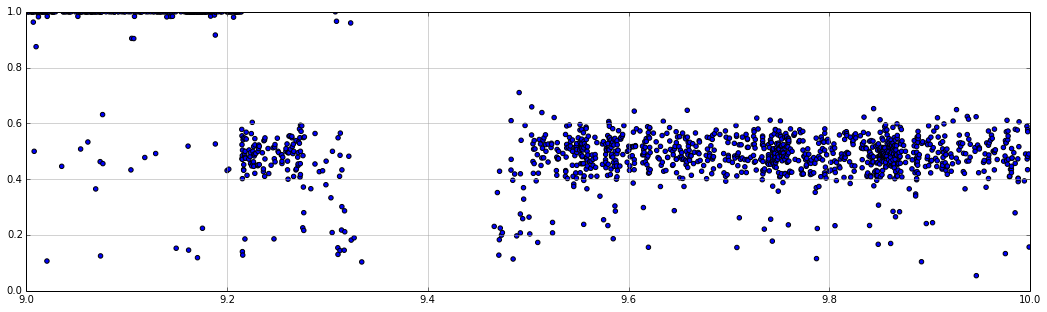

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount
588,9,6595000,1,9.046702,23744000,1.000000,2174
589,9,30339000,2,9.214845,622999,0.533885,10
591,9,30963000,2,9.219264,153999,0.518519,23
593,9,31119000,2,9.220369,1305999,0.533333,64
598,9,32536000,2,9.230403,322999,0.531129,6
615,9,33116000,2,9.234510,112999,0.552530,10
651,9,34159000,2,9.241896,235999,0.531361,12
665,9,34582000,3,9.244892,133000,0.563636,7
667,9,34729000,2,9.245933,146999,0.554567,6
669,9,34894000,2,9.247101,88999,0.523226,12


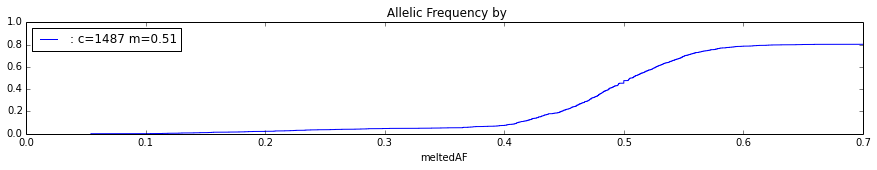

In [252]:
c,fractionMin,fractionMax = 9,0,1
dfTemp = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfTemp.chromPos, dfTemp.BAF,c+fractionMin, c+fractionMax)
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

#CDF
ser = dfSom.meltedAF.sort_values()
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = pd.Series(cum_dist, index=ser,name=": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,2],xlim=[0.0,0.7])

#mbaf
dfTumorCNV[(dfTumorCNV.chromPos>c+fractionMin)&(dfTumorCNV.chromPos<c+fractionMax)&(dfTumorCNV.mBAFCount>5)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

### Somatic Peak Finding

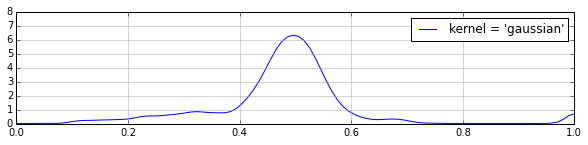

[0.05, 0.32, 0.49, 0.67]

In [217]:
X = dfSom.meltedAF.sort_values()[:, np.newaxis]
X_plot = np.linspace(0,1,100)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens)
findPeaks(log_dens,1)

### SCRATCH

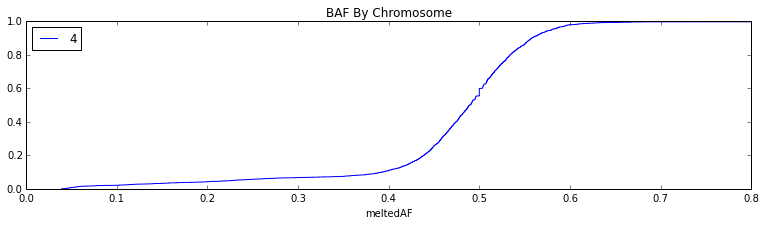

In [34]:
chromosomes = ['4']#dfSomatic['chrom'].unique()
for chromosome in chromosomes:
    try:
        ser = dfSomatic[(dfSomatic.chrom==chromosome)&(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)]["meltedAF"]
        ser = ser.sort_values()
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=str(chromosome))
        ser_cdf.plot(drawstyle='steps',legend=True,title="BAF By Chromosome",figsize=[13,3],xlim=[0.0,0.8],ylim=[0.0,1.0])
    except TypeError:
        continue

### RATIO

In [94]:
dfTumorRatio = pd.read_table(PATH + tumorRatioFileName, header=0)#names = ['chrom','window',"ratio","segmentRatio","copyNum","mbaf","baf","GT","uncertainty"] )
dfNormalRatio = pd.read_table(PATH + normalRatioFileName, header=0)# names = ['chrom','window',"ratio","segmentRatio","copyNum","mbaf","baf","GT","uncertainty"] )
dfTumorRatio.set_index(['Chromosome','Start'],inplace=True)
dfNormalRatio.set_index(['Chromosome','Start'],inplace=True)
dfTumorRatio = pd.merge(dfTumorRatio,dfNormalRatio,how='inner', left_index=True,right_index=True)
#dfTumorRatio = dfTumorRatio[(dfTumorRatio.Ratio_y > 0)]
dfTumorRatio['ratio']= pd.to_numeric(dfTumorRatio['Ratio_x'],errors=coerce) /pd.to_numeric(dfTumorRatio['Ratio_y'],errors=coerce)
dfTumorRatio = dfTumorRatio.reset_index()
dfTumorRatio['chromPos'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x))) + \
    dfTumorRatio['Start']/dfTumorRatio['Chromosome'].map(lambda x: cd.chromosomeLength[str(x)])
dfTumorRatio['Chromosome'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x)))

/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [97]:
dfTumorCNV['nonZeroCount'],dfTumorCNV['tumorRatio'],dfTumorCNV['normalRatio'] \
    ,dfTumorCNV['tumorMedianRatio'],dfTumorCNV['normalMedianRatio'] = \
    np.vectorize(nonZeroCountBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])
dfTumorCNV['ratioOfRatio']=dfTumorCNV.tumorRatio/dfTumorCNV.normalRatio

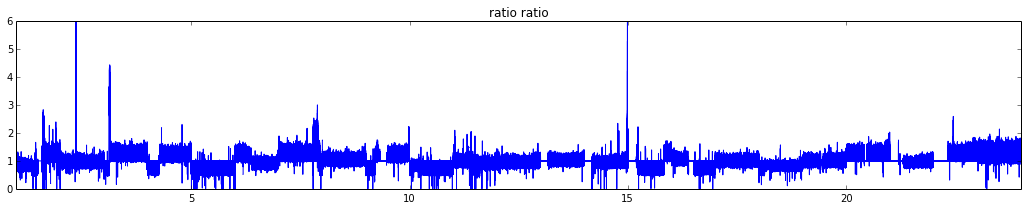

In [157]:
positionChart(dfTumorRatio,"ratio","ratio",1,24,6)

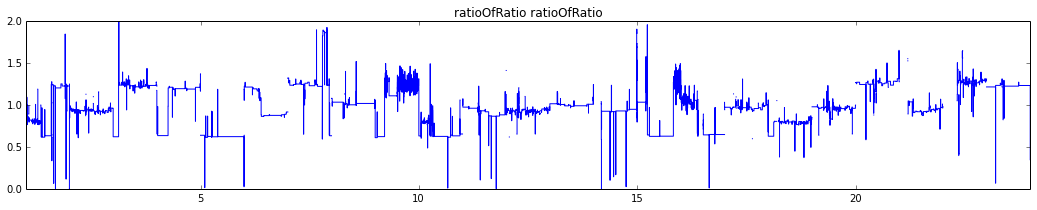

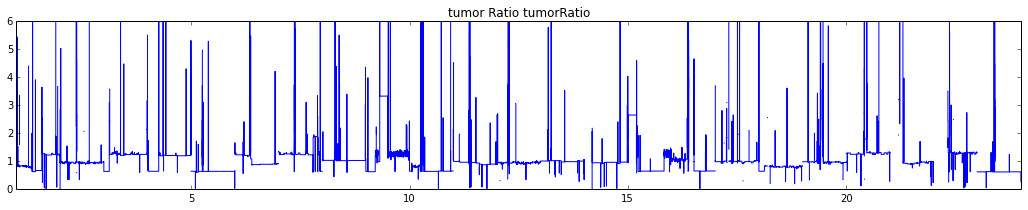

In [164]:
positionChart(dfTumorCNV,"ratioOfRatio","ratioOfRatio",1,24,2)
positionChart(dfTumorCNV,"tumor Ratio","tumorRatio",1,24,6)

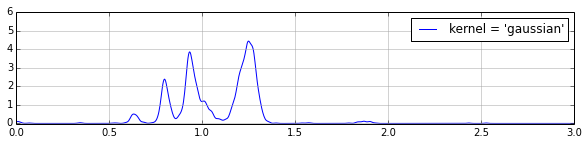

In [220]:
X = dfTumorCNV[dfTumorCNV.nonZeroCount>10].ratioOfRatio.sort_values()[:, np.newaxis]
X_range = 3
X_plot = np.linspace(0,X_range,1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.010).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens,6)
cnvPeaks = findPeaks(log_dens,X_range)

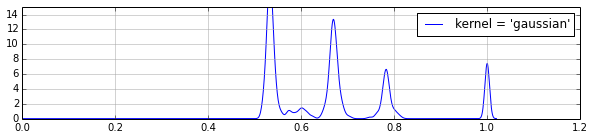

In [219]:
X = dfTumorCNV[dfTumorCNV.mBAFCount>10].mBAF.sort_values()[:, np.newaxis]
X_range = 1.02
X_plot = np.linspace(0,X_range,1020)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.005).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens,15)
mBAFPeaks = findPeaks(log_dens,X_range)

In [169]:
dfTumorCNV['fittedBAFPeak'] = np.vectorize(fitBAFPeak)(dfTumorCNV['mBAF'])
dfTumorCNV['fittedCNVPeak'] = np.vectorize(fitCNVPeak)(dfTumorCNV['ratioOfRatio'])
pd.pivot_table(dfTumorCNV, values='mBAFCount', index=['fittedBAFPeak'], columns=['fittedCNVPeak'], aggfunc='sum',margins=True).fillna("")

fittedCNVPeak,0.009,0.066,0.342,0.519,0.531,0.63,0.795,0.93,1.008,1.245,1.395,1.533,1.569,1.782,1.839,1.866,1.896,2.43,2.523,All
fittedBAFPeak,,,,,,,,,,,,,,,,,,,,
0.532,1,0,0,0,0,3393,0,0,6962,44188,170,3,4,0,,0,0,,0,54721.0
0.574,,,,,,157,,,9946,233,15,1,,,,,,,,10352.0
0.601,4,,,,,,,8,2052,24,2,1,,1,,,,,,2092.0
0.669,2,,,,,,,36296,3345,7,,,,16,246,556,321,,,40789.0
0.748,,,,,,,256,14,9,1,,,,,,,1,66,,347.0
0.782,,,,,,,10519,1,,,,,,,,,,,89,10609.0
0.999,3,,,56,,34631,1,12884,1604,6604,,,,,24,,,,,55807.0
All,10,0,0,56,0,38181,10776,49203,23918,51057,187,5,4,17,270,556,322,66,89,174717.0


### GENE CNV ANALYSIS

In [ ]:
# BEST ESTIMATE OF COPY NUMBER!
dfTumorCNV["myCopyNum"] = np.round(dfTumorCNV.fittedCNVPeak/0.63*2,0)

In [136]:
# LOAD CNV BED
CNV_BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
CNV_BED_FILE_NAME = "cosmicCurated.bed" 
CNVBed = aVCF.loadBEDFile(CNV_BED_PATH,CNV_BED_FILE_NAME)

In [190]:
dfGeneCNV = pd.DataFrame(runGeneCNVAnalysis(dfTumorCNV,CNVBed,'COLO829'),columns= GENECNV_COLUMNS)

In [249]:
(dfGeneCNV[dfGeneCNV.minCopyNum==2])

,patientName,gene,chrom,posStart,posEnd,minCopyNum,cnvLabel
9,COLO829,RPL5,1,93297672,93307422,2.0,normal
10,COLO829,NRAS,1,115251156,115258781,2.0,normal
11,COLO829,ATP1A1,1,116916134,116947066,2.0,normal
12,COLO829,NOTCH2,1,120457929,120612020,2.0,normal
27,COLO829,VHL,3,10183532,10191649,2.0,normal
42,COLO829,FGFR3,4,1795662,1808989,2.0,normal
43,COLO829,PHOX2B,4,41747824,41750627,2.0,normal
50,COLO829,TERT,5,1253843,1295104,2.0,normal
51,COLO829,IL7R,5,35857080,35876588,2.0,normal
52,COLO829,IL6ST,5,55236910,55272106,2.0,normal


In [251]:
dfSomatic[(dfSomatic.annWorstImpact=='HIGH')&(dfSomatic.bedRegion<>'')].sort_values('annGene')

,chrom,pos,chromPos,chromFrac,id,ref,vennSegment,numCallers,variantType,variantSubType,filter,bedRegion,inDBSNP,inCOSMIC,annGene,annWorstImpact,annWorstEffect,annAllEffects,consensus,meltedallele,meltedAF,meltedDP,meltedQS,meltedSGT,meltedindelDiff,meltedSVLenMin,meltedSVLenMax,meltedSVStartMin,meltedSVStartMax,patientName,alt,PONCount,inPON
40869,9,21971153,9:21971153,9.155588,COSM13592,CCG,freebayes-strelka-varscan,3,INDEL,DELETE,PASS,ENST00000498124.1 (CDKN2A),False,True,CDKN2A,HIGH,frameshift_variant,frameshift_variant|frameshift_variant|frameshi...,True,C,1.0,38,-1.0,0/1,CG-,,,,,COLO829,C,0,False
